# Virgo Exercise

The aim of the exercise is to prepare a ML tool which is able to compress as much as possible a gwf data 

In this exercise you will:

- explore the content of an open dataset from IGWN containing the strain in function of time
- try to plot quantities and understand what can be used
- train various (?) network type in order to perform the job, and test their abilities; this can be done at various complexity levels


We will import all functions needed!
*gwdama* aims at providing a unified and easy to use interface to access Gravitational Wave (GW) data and output some well organised datasets, ready to be used for Machine Learning projects or Data Analysis purposes (source properties, noise studies, etc.)

In [31]:
from gwdama.io import GwDataManager
import numpy as np
from scipy.stats import norm
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

Data is accessible and ordered by gps time
At https://www.gw-openscience.org/events/ you could find a list of events with their gps time and a brief description of the results
Let's get data between 1186746568 and 1186746628 and call it "online"

In [3]:
event_gps = 1186746618  
dama = GwDataManager()
dama.read_gwdata(event_gps - 50, event_gps +10, ifo='L1',data_source="gwosc-online",dts_key='online')

In [6]:
print(dama)

mydama:
  └── online

  Attributes:
     dama_name : mydama
    time_stamp : 21-04-21_10h50m25s



data acquisition is 21-04-21_10h50m25s
To acquire some confidence with data we will start with a plot

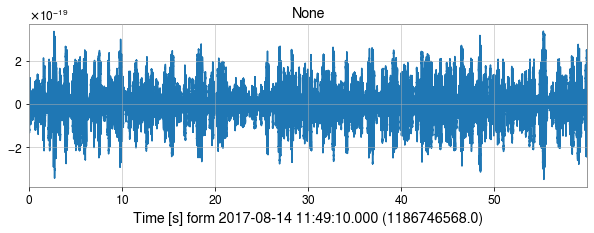

In [10]:
online=dama['online']
online.plot()

Note: the timestamp is different because internally in the IGWN we use a different convention

**Exercise**: read multiple files and plot them with a single for loop

Now we will make an histogram of data and fit with a gaussian

In [20]:
myplot = online.hist()
mu, std = norm.fit(online.data)

Customize the plot, adding the fitted gaussian and a legend

In [22]:
ax = myplot.gca()
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'r--', linewidth=1, label='Gaussian fit')
ax.legend()

myplot.reshow()                    # New method to re-show closed figures

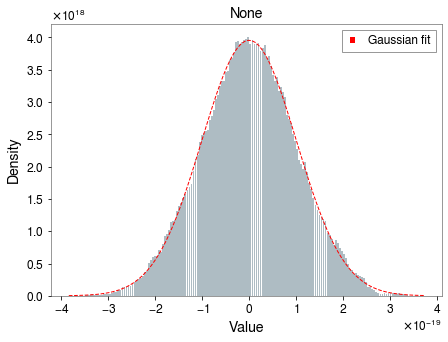

In [23]:
myplot

Create a psd with sample rate 500 Hz

In [24]:
fs = 500
online.attrs['sample_rate'] = fs
online.psd(2,1)

<HDF5 dataset "online_psd": shape (513,), type "|V16">

In [26]:
print(dama)

mydama:
  ├── online
  └── online_psd

  Attributes:
     dama_name : mydama
    time_stamp : 21-04-21_10h50m25s



The psd is added to our dataset with name_psd

Now plot the PSD

In [45]:
fig, ax = plt.subplots()
ax.semilogy('freq', 'PSD', data=dama['online_psd'], alpha=.7, label='online_psd')

ax.legend()
ax.set_ylim(1e-5,1)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD [1/Hz]')
plt.show()

In [ ]:
# and clean it
online_cleaned = whiten(online, dama['online_psd'].data, 1./500)

It could be usefull to resample the data in order to work with lighter files

In [ ]:
online_res, new_fs = dama.decimate_recursive(online_cleaned, 10)

if you want to get more information on data and the cleaning process here a usefull link https://github.com/losc-tutorial/Data_Guide/blob/master/Guide_Notebook.ipynb

Once data is ready we can try to encode with an **autoencoder**

[from wiki]: An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learned, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name

The idea is to downsampling and resampling to original dimension searching for an optimum parameters that makes filtered signal more similar to original one. The downsampled signal will retain all needed information but with a reduction of size

To make our statement more concise we will summary some ideas on Artificial Neural Networks and Deep Learning

## Artificial Neural networks 

**Artificial neural networks (ANNs)** are computing systems vaguely inspired by the biological neural networks that constitute animal brains.

An ANN is based on a collection of connected units or nodes called artificial neurons, which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit a signal to other neurons. An artificial neuron that receives a signal then processes it and can signal neurons connected to it. The "signal" at a connection is a real number, and the output of each neuron is computed by some non-linear function of the sum of its inputs. The connections are called edges. Neurons and edges typically have a weight that adjusts as learning proceeds. The weight increases or decreases the strength of the signal at a connection. Neurons may have a threshold such that a signal is sent only if the aggregate signal crosses that threshold. Typically, neurons are aggregated into layers. Different layers may perform different transformations on their inputs. Signals travel from the first layer (the input layer), to the last layer (the output layer), possibly after traversing the layers multiple time and along different paths

Artificial networks could be build by many layers, each one connected to each others. There are amny types of networks. For example:

A **feedforward neural network** is an artificial neural network wherein connections between nodes do not form a cycle, layers are connected starting from the top (input) to the bottom (output) and the activation flows from top to the end exclusively

A **recurrent neural network (RNN)** is a class of artificial neural networks where connections between nodes form a directed graph along a temporal sequence. This allows it to exhibit temporal dynamic behavior. Derived from feedforward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs. Typically part of output of one layer is feed as input to the same layer at a different time

[https://en.wikipedia.org/wiki/Artificial_neural_network]

## Layers

**Layers** are group of nodes that mimic some concepts. Each node inside the layer shares same input and output and the same activation function

## Activation function

The **activation function** of a node defines the output of that node given an input or set of inputs. Experience shows that only nonlinear activation functions allow networks to compute nontrivial problems using only small number of nodes

- **rectifier or ReLU** activation function is an activation function defined as the positive part of its argument

- **Sigmoid** activation function is an activation function which applies a sigmoid to the input. The assumption here is that we are interested in intermediate value of input, so we treat them in a liner way, greater values in modulo are not so important because are extreme and show fewer variation

[ https://en.wikipedia.org/wiki/Activation_function ]

## Learning 

**Supervised learning** is the machine learning task of learning a function that maps an input to an output based on example input-output pairs

**Unsupervised learning** is the task of learning a function that maps an input to an output based on some cost function

## Restatement of the task

An autoencoder has an input layer, an output layer and one or more hidden layers connecting them. The output layer has the same number of units as the input layer. Its purpose is to reconstruct its own inputs. Therefore, autoencoders are unsupervised learning models. We want our autoencoder to efficient codings using unsupervised learning

**Question**: Could an autoencoder have only a single layer? Two layers? Three?

In the following we will use keras ( https://keras.io/ )
"Keras is an API designed for human beings, not machines. Keras follows best practices for reducing cognitive load: it offers consistent & simple APIs, it minimizes the number of user actions required for common use cases, and it provides clear & actionable error messages. It also has extensive documentation and developer guides."

Some usefull info:

- https://blog.keras.io/building-autoencoders-in-keras.html

- https://keras.io/api/models/

In the following we will use a slightly different approch from usual, instead of using a single command, we use sklearn as interface to call other functions. The idea is to learn to wrap Keras models for use in scikit-learn and how to use grid search. "GridSearchCV is a library function that is a member of sklearn's model_selection package. It helps to loop through predefined hyperparameters and fit your estimator (model) on your training set. So, in the end, you can select the best parameters from the listed hyperparameters" 

[https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html ] 

[https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ ]

Some layers used in keras:

- **dense** layer makes output=activation(dot(input, kernel) + bias) where kernel is the matrix of parameters and activation is the activation function

- **Dropout** layer randomly sets input units to 0 with a frequency of rate at each step during training time. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged

## Simple example

A skeleton will take input, import relevant functions, define a model, optimize it and test it

Let's start!

In [ ]:
# input
# we will split our data in chunk of n elements and we will feeds our network with all these chunks
n_features = 100 # is the size of a single chunk of data

# add a normal dataset to dama
dama.create_dataset('random_n', data=np.random.normal(0, 1, (10000,)))

# access its data and store in variable input_data
input_data = dama['random_n'].data

# split data in chunks of 100 element each one and stack each chunk vertically
chunks = np.stack(np.split(input_data,100))
chunks.shape

In [ ]:
import math

from keras import optimizers
from keras.optimizers import Nadam

from keras import regularizers

from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, TimeDistributed

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

import joblib

In [ ]:
# a very simple model, feedforward neural network with two layers and with two different activation functions
def baseline_model(bias1=1e-9, bias2=1e-9, ker1=1e-9, ker2=1e-9):
  
    model = Sequential()
    model.add(Dense(n_features, activation='relu', input_shape=(n_features,), bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model.add(Dense(n_features, activation='sigmoid', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))

    model.compile(optimizer=Nadam(lr=5e-6), loss='mse', metrics=['mse'])

    return model

In [ ]:
# machine learning
# epochs is usetd for recurrent networks, we don't need them so we set to 1
# batch_size is the number of input chunks
mlp = KerasRegressor(build_fn=baseline_model, epochs=1, batch_size=n_features, verbose=0)

In [ ]:
# space of parameters used when call our model
param_distr = dict(bias1 = [1e-9], bias2 = [1e-9], ker2 = [1e-9], ker1 = [1e-9])

In [ ]:
# build our model all together
grid_search = GridSearchCV(estimator=mlp, param_grid=param_distr, cv=3)

In [ ]:
# fit it
# vay all nodes based on param_distr to make output "near" to input. Near here mean output of a distance function 'mse' 
grid_search.fit(chunks, chunks)

In [ ]:
# get some info
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means  = grid_search.cv_results_['mean_test_score']
stds   = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

**Question**: Is output data only positive? why?

## Exercise 1: Alter input and model to have in output value between a different range

## Exercise 2: example with real data

We need to follow exactly what we did before but using our gw data insetad of our simulated data

Recall that to get data from dama you could use "dama['random_n'].data" 

In real life before start we will have to decide what will be
- our chunk size
- our metric

using frequency and other values as starting point

We can however start with an (nearly!) arbitrary value and see what will happen



## Exercise 3: Alter model, adding a decimate layer and a new dense layer

## Exercise 4 (long): Build a complex model which takes as input signal at different freq

## Exercise 5: Plot output data and compare with input signal

## Exercise 6: Save output files and compute their size and their entropy